Studia podyplomowe - Data Science: zaawansowana analiza danych
# Analiza i prognoza promieniowania słonecznego
Autor: Patrycja Kopciuch

____________
Project objectives:
Analysis and prediction of solar radiation based on data collected and provided by NASA as part of the HI-SEAS project (Hawai’i Space Exploration Analog and Simulation project)

Data source:  https://www.dropbox.com/sh/g0gf1awqqaumyqt/AAB1G07PaBYjUnOYnXOLx9eua?dl=0

More information:
https://hi-seas.org/
https://2017.spaceappschallenge.org/challenges/earth-and-us/you-are-my-sunshine/details


#Note: range sliders and range selectors are available in version 1.9.7+
#Run pip install plotly --upgrade to update your Plotly version

#https://plot.ly/python/range-slider/
________________________________________________________________________________________________________________________________

HI-SEAS project was an analog habitat placed on the isolated, Mars-like side of Manua Loa volcano. It was run to determine what is required to keep the space flight crew in good conditions during an extended mission to Mars and while living on this planet. One of the most important ascpect of living there is energy, which was only provided by solar panels. Baterries were charging since sunset till the end of the day. Importance of the weather conditions is undienable, the bad ones could cause a huge problem for the crew and the whole project as it might lead to continuous energy shortages. 
Our purpose is prediction of solar radiation based on data of weather conditions, which were collected for four months of 2016. It could be very helpful for crew to know how to manage energy resources.

<img src="habitat.png" width="700" height="500"/>

<img src="rossSuit.jpg" width="700" height="500"/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd  
import seaborn as sns
import datetime as dt
from IPython.display import Image
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import *
from sklearn import preprocessing
from datetime import timedelta
import scipy as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Our data are stored in separate files, then our first task is to join them into one table using pandas library.

We are going to upload our data, but first thing which is expected to do is reviewing data structure. They do not have headears, then we need to remember to set header as None.

In [2]:
rad = pd.read_csv("solar radiation.csv", sep = ',', header = None)
bp = pd.read_csv("barometric pressure.csv", sep = ',', header = None)
hum = pd.read_csv("humidity.csv", sep = ',', header = None)
temp = pd.read_csv("temperature.csv", sep = ',', header = None)
wdir = pd.read_csv("wind direction in degrees.csv", sep = ',', header = None)
wspeed = pd.read_csv("wind speed.csv", sep = ',', header = None)
srise = pd.read_csv("sunrise.csv", sep = ',', header = None)
sset = pd.read_csv("sunset.csv", sep = ',', header = None)

According to the enclosed  data description each feature has columns as below:

    - Record number;
    - UNIXTime - number of seconds that have elapsed since 00:00:00 Thursday, 1 January 1970
    - Date of observation, format yyyy-mm-dd
    - Time of observation, format hh:mm:ssc- local time: GMT-10
    - Features: barometric pressure - unit: Hg - 1Hg = 133,32 Pa
                       air humidity - unit: % - percentage of steam saturation in the air
                       solar radiation - unit: W/m^2
                       temperature - unit: Fahrenheit degree
                       wind direction - unit: degree, range from 0 to 360
                       wind speed- unit: miles/hour
                       Sunset time - format hh:mm
                       Sunrise time - format hh:mm
      
Let's assign to each column corresponding headers.

In [3]:
cols = ['Solar_Radiation', 'Pressure', 'Humidity', 'Temperature', 'Wind_Direction', 'Wind_Speed', 'Sunrise_Time', 'Sunset_Time']
features = [rad, bp, hum, temp, wdir, wspeed, srise, sset]

for i in range(len(features)):
        features[i].columns = ['Index', 'UNIXTime', 'Date', 'Obs_Time', cols[i], 'None']

In [4]:
for x in features:
    print('\033[1m' + x.columns[4] + '\033[0m')
    display(x.head(2))

Solar_Radiation


,Index,UNIXTime,Date,Obs_Time,Solar_Radiation,None
0,1,1475315718,2016-09-30,23:55:18,1.27,NaN
1,2,1475315423,2016-09-30,23:50:23,1.25,NaN


Pressure


,Index,UNIXTime,Date,Obs_Time,Pressure,None
0,1,1475315718,2016-09-30,23:55:18,30.46,NaN
1,2,1475315423,2016-09-30,23:50:23,30.46,NaN


Humidity


,Index,UNIXTime,Date,Obs_Time,Humidity,None
0,1,1475315718,2016-09-30,23:55:18,80,NaN
1,2,1475315423,2016-09-30,23:50:23,79,NaN


Temperature


,Index,UNIXTime,Date,Obs_Time,Temperature,None
0,1,1475315718,2016-09-30,23:55:18,48,NaN
1,2,1475315423,2016-09-30,23:50:23,48,NaN


Wind_Direction


,Index,UNIXTime,Date,Obs_Time,Wind_Direction,None
0,1,1475315718,2016-09-30,23:55:18,151.95,NaN
1,2,1475315423,2016-09-30,23:50:23,176.14,NaN


Wind_Speed


,Index,UNIXTime,Date,Obs_Time,Wind_Speed,None
0,1,1475315718,2016-09-30,23:55:18,7.87,NaN
1,2,1475315423,2016-09-30,23:50:23,7.87,NaN


Sunrise_Time


,Index,UNIXTime,Date,Obs_Time,Sunrise_Time,None
0,1,1475229600,2016-09-30,00:00:00,613,NaN
1,2,1475143200,2016-09-29,00:00:00,613,NaN


Sunset_Time


,Index,UNIXTime,Date,Obs_Time,Sunset_Time,None
0,1,1475229600,2016-09-30,00:00:00,1812,NaN
1,2,1475143200,2016-09-29,00:00:00,1813,NaN


We see the UNIXTime, Sunset_Time i Sunrise_Time values aren't readable enough. Let's convert them using pd_to.datetime.

In [5]:
for x in features:
    x["UNIXTime"] = pd.to_datetime(x["UNIXTime"], unit = 's')
    x["Date"] = pd.to_datetime(x["Date"]).dt.date
    x["Obs_Time"] = pd.to_datetime(x["Obs_Time"], format = '%H:%M:%S').dt.time

In [6]:
srise["Sunrise_Time"] = srise["Sunrise_Time"].astype(str)
srise["Sunrise_Time"] = "0" + srise["Sunrise_Time"].str.slice(0,1) + ":" + srise["Sunrise_Time"].str.slice(1,3) + ":00"
srise["Sunrise_Time"] = pd.to_datetime(srise["Sunrise_Time"]).dt.time


sset["Sunset_Time"] = sset["Sunset_Time"].astype(str)
sset["Sunset_Time"] = sset["Sunset_Time"].str.slice(0,2) + ":" + sset["Sunset_Time"].str.slice(2,4) + ":00"
sset["Sunset_Time"] = pd.to_datetime(sset["Sunset_Time"]).dt.time

In [7]:
for x in features:
    print('\033[1m' + x.columns[4] + '\033[0m')
    display(x.head(2))

Solar_Radiation


,Index,UNIXTime,Date,Obs_Time,Solar_Radiation,None
0,1,2016-10-01 09:55:18,2016-09-30,23:55:18,1.27,NaN
1,2,2016-10-01 09:50:23,2016-09-30,23:50:23,1.25,NaN


Pressure


,Index,UNIXTime,Date,Obs_Time,Pressure,None
0,1,2016-10-01 09:55:18,2016-09-30,23:55:18,30.46,NaN
1,2,2016-10-01 09:50:23,2016-09-30,23:50:23,30.46,NaN


Humidity


,Index,UNIXTime,Date,Obs_Time,Humidity,None
0,1,2016-10-01 09:55:18,2016-09-30,23:55:18,80,NaN
1,2,2016-10-01 09:50:23,2016-09-30,23:50:23,79,NaN


Temperature


,Index,UNIXTime,Date,Obs_Time,Temperature,None
0,1,2016-10-01 09:55:18,2016-09-30,23:55:18,48,NaN
1,2,2016-10-01 09:50:23,2016-09-30,23:50:23,48,NaN


Wind_Direction


,Index,UNIXTime,Date,Obs_Time,Wind_Direction,None
0,1,2016-10-01 09:55:18,2016-09-30,23:55:18,151.95,NaN
1,2,2016-10-01 09:50:23,2016-09-30,23:50:23,176.14,NaN


Wind_Speed


,Index,UNIXTime,Date,Obs_Time,Wind_Speed,None
0,1,2016-10-01 09:55:18,2016-09-30,23:55:18,7.87,NaN
1,2,2016-10-01 09:50:23,2016-09-30,23:50:23,7.87,NaN


Sunrise_Time


,Index,UNIXTime,Date,Obs_Time,Sunrise_Time,None
0,1,2016-09-30 10:00:00,2016-09-30,00:00:00,06:13:00,NaN
1,2,2016-09-29 10:00:00,2016-09-29,00:00:00,06:13:00,NaN


Sunset_Time


,Index,UNIXTime,Date,Obs_Time,Sunset_Time,None
0,1,2016-09-30 10:00:00,2016-09-30,00:00:00,18:12:00,NaN
1,2,2016-09-29 10:00:00,2016-09-29,00:00:00,18:13:00,NaN


It looks better now. We need to remember the UNIXTime is UTC, while the local Hawaii time is UTC-10, then there are discrepancies between UNIXTime and Date i Obs_Time. 

Let's check the length (number of records) of each table.

In [8]:
for x in features:
    print('\033[1m' + x.columns[4] + '\033[0m',len(x), '\n')

Solar_Radiation 33133 

Pressure 33133 

Humidity 33133 

Temperature 33133 

Wind_Direction 33133 

Wind_Speed 33133 

Sunrise_Time 121 

Sunset_Time 121 



All the tables with the exception of Sunrise_Time and Suset_Time have the same length. Then we can merged them using "UNIXTime" as the common attribute. Sunrise_Time and Suset_Time tables have significantly less records, because one measurement per day is sufficient. Then number of records equals to total number of days between September 2016 and December 2016. These tables will be merged using "Date" as a common key.

Let's remove all the unnecessary columns (these ones, which would duplicate after tables merging).

In [9]:
rad = rad.drop(['Index','None'], axis =1)
features_1 = [bp, hum, temp, wdir, wspeed]
features_2 = [srise, sset]
for i in range(len(features_1)):
    features_1[i] = features_1[i].drop(['Index', 'None', 'Date', 'Obs_Time'], axis = 1, inplace = True)
for j in range(len(features_2)):
    features_2[j] = features_2[j].drop(['Index', 'None', 'UNIXTime', 'Obs_Time'], axis = 1, inplace = True)

In [10]:
features = [rad, bp, hum, temp, wdir, wspeed, srise, sset]

In [11]:
for x in features:
    print('\033[1m' + x.columns[-1] + '\033[0m')
    display(x.head(2))

Solar_Radiation


,UNIXTime,Date,Obs_Time,Solar_Radiation
0,2016-10-01 09:55:18,2016-09-30,23:55:18,1.27
1,2016-10-01 09:50:23,2016-09-30,23:50:23,1.25


Pressure


,UNIXTime,Pressure
0,2016-10-01 09:55:18,30.46
1,2016-10-01 09:50:23,30.46


Humidity


,UNIXTime,Humidity
0,2016-10-01 09:55:18,80
1,2016-10-01 09:50:23,79


Temperature


,UNIXTime,Temperature
0,2016-10-01 09:55:18,48
1,2016-10-01 09:50:23,48


Wind_Direction


,UNIXTime,Wind_Direction
0,2016-10-01 09:55:18,151.95
1,2016-10-01 09:50:23,176.14


Wind_Speed


,UNIXTime,Wind_Speed
0,2016-10-01 09:55:18,7.87
1,2016-10-01 09:50:23,7.87


Sunrise_Time


,Date,Sunrise_Time
0,2016-09-30,06:13:00
1,2016-09-29,06:13:00


Sunset_Time


,Date,Sunset_Time
0,2016-09-30,18:12:00
1,2016-09-29,18:13:00


We are going to join tables: ['Solar_Radiation', 'Pressure', 'Humidity', 'Temperature', 'Wind_Direction', 'Wind_Speed'] using reduce function. The common attribute for them is UNIXTime.

In [12]:
from functools import reduce
merged = reduce(lambda  left,right: pd.merge(left, right,on=['UNIXTime'], how='inner'), [rad, bp, hum, temp, wdir, wspeed])

In [13]:
merged.head(3)

,UNIXTime,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed
0,2016-10-01 09:55:18,2016-09-30,23:55:18,1.27,30.46,80,48,151.95,7.87
1,2016-10-01 09:50:23,2016-09-30,23:50:23,1.25,30.46,79,48,176.14,7.87
2,2016-10-01 09:45:24,2016-09-30,23:45:24,1.25,30.46,79,48,177.54,9.00


Atfer first merging we will join two remaining tables with "merged" using "Date".

In [14]:
final_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), [merged, srise, sset])

To make code more transaprent let's assume fm:= final_merged.

In [15]:
fm = final_merged

We have all the data in one table, so we can remove column "UNIXTime" as it won't be useful anymore.

In [16]:
fm.drop("UNIXTime", axis = 1, inplace = True)

In [17]:
fm.head()

,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed,Sunrise_Time,Sunset_Time
0,2016-09-30,23:55:18,1.27,30.46,80.0,48.0,151.95,7.87,06:13:00,18:12:00
1,2016-09-30,23:50:23,1.25,30.46,79.0,48.0,176.14,7.87,06:13:00,18:12:00
2,2016-09-30,23:45:24,1.25,30.46,79.0,48.0,177.54,9.00,06:13:00,18:12:00
3,2016-09-30,23:40:21,1.25,30.46,79.0,48.0,167.56,13.50,06:13:00,18:12:00
4,2016-09-30,23:35:22,1.27,30.47,79.0,48.0,177.81,15.75,06:13:00,18:12:00


In [18]:
fm.info(), fm.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33135 entries, 0 to 33134
Data columns (total 10 columns):
Date               33135 non-null object
Obs_Time           33133 non-null object
Solar_Radiation    33133 non-null float64
Pressure           33133 non-null float64
Humidity           33133 non-null float64
Temperature        33133 non-null float64
Wind_Direction     33133 non-null float64
Wind_Speed         33133 non-null float64
Sunrise_Time       32967 non-null object
Sunset_Time        32967 non-null object
dtypes: float64(6), object(4)
memory usage: 2.8+ MB


(None, (33135, 10))

Looking at the above summary it's clear there are missing values in our table. Only column 'Date' has no null objects (comparing to the shape of table). Let's check then, where the null-values are.

In [19]:
missing_val = fm[fm.isnull().any(axis=1)]
missing_val.isnull().sum(), len(missing_val)

(Date                 0
 Obs_Time             2
 Solar_Radiation      2
 Pressure             2
 Humidity             2
 Temperature          2
 Wind_Direction       2
 Wind_Speed           2
 Sunrise_Time       168
 Sunset_Time        168
 dtype: int64, 170)

For the Sunrise/Sunset Time we see missing data for the 30th November 2016. As the variance between following sunrise/sunset times is maximum 1 minute we just assume the missing data are the same as for the next day (1st of December 2016).

In [20]:
fm[fm['Sunrise_Time'].isnull()].head()

,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed,Sunrise_Time,Sunset_Time
16517,2016-11-30,23:55:04,1.19,30.43,101.0,44.0,133.95,9.00,NaN,NaN
16518,2016-11-30,23:50:02,1.22,30.43,101.0,44.0,105.88,12.37,NaN,NaN
16519,2016-11-30,23:45:05,1.20,30.43,101.0,44.0,156.49,6.75,NaN,NaN
16520,2016-11-30,23:40:05,1.15,30.43,101.0,44.0,60.14,2.25,NaN,NaN
16521,2016-11-30,23:35:05,1.26,30.43,101.0,45.0,80.24,1.12,NaN,NaN


In [21]:
print(fm[fm['Sunrise_Time'].isnull()].Date.unique())

[datetime.date(2016, 11, 30)]


In [22]:
fm["Sunrise_Time"] = fm.Sunrise_Time.fillna(fm.Sunrise_Time[fm["Date"].astype(str) == "2016-12-01"].values[1])
fm["Sunset_Time"] = fm.Sunset_Time.fillna(fm.Sunset_Time[fm["Date"].astype(str) == "2016-12-01"].values[1])

In [1]:
if(fm.Sunrise_Time.isnull().sum()==0):
    print("There are no missing values for Sunrise_Time and Sunset_Time")

NameError: name 'fm' is not defined

Looking at the below there are missing values for the other features for two days 2016-12-06 and 2016-12-07. However it is less than 2% of all days, so we can suppose they hardly have an impact on the results of analysis. 

In [24]:
fm[fm['Solar_Radiation'].isnull()].head()

,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed,Sunrise_Time,Sunset_Time
33133,2016-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:45:00,17:43:00
33134,2016-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:44:00,17:43:00


In [25]:
print(fm[fm['Solar_Radiation'].isnull()].Date.unique())

[datetime.date(2016, 12, 7) datetime.date(2016, 12, 6)]


In [26]:
print("Missing data for mentioned two days are "+ "{0:.5%}".format(missing_val.Solar_Radiation.isnull().sum()/len(fm.Date.unique())) + " of total data.")

Brakujące dane z powyższych dni stanowią 1.63934% całego zbioru.


In [27]:
fm.dropna(inplace = True)

In [28]:
fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33133 entries, 0 to 33132
Data columns (total 10 columns):
Date               33133 non-null object
Obs_Time           33133 non-null object
Solar_Radiation    33133 non-null float64
Pressure           33133 non-null float64
Humidity           33133 non-null float64
Temperature        33133 non-null float64
Wind_Direction     33133 non-null float64
Wind_Speed         33133 non-null float64
Sunrise_Time       33133 non-null object
Sunset_Time        33133 non-null object
dtypes: float64(6), object(4)
memory usage: 2.8+ MB


Let's add a few columns/attributes, which may be helpful later.

  - "Obs_Hour" - time measurements approximated to the hour (treated as taken on the hour)
  - "Date&Hour" - concatenation of "Date" i "Obs_Hour"
  - "Day/Night" - have two values: "Day" if observation has taken place between Sunrise nad Sunset time or "Night" in other case 
  - "Week" - number of week in the year
  - "Month" - month name

In [29]:
fm["Obs_Hour"] = fm["Obs_Time"].astype(str).apply(lambda x: x[:2] if x!="NaT" else None)
fm["Date&Hour"] = fm["Date"].map(str) + " " + fm["Obs_Hour"]
fm["Day/Night"] = np.where(((fm.Obs_Time>fm.Sunrise_Time) & 
                                      (fm.Obs_Time<fm.Sunset_Time)) ==True, "Day", "Night")
fm["Week"] = pd.to_datetime(fm["Date"]).dt.week.astype(str)
fm["Month"] = pd.to_datetime(fm["Date"]).dt.strftime("%B")

In [30]:
fm.head(3)

,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed,Sunrise_Time,Sunset_Time,Obs_Hour,Date&Hour,Day/Night,Week,Month
0,2016-09-30,23:55:18,1.27,30.46,80.0,48.0,151.95,7.87,06:13:00,18:12:00,23,2016-09-30 23,Night,39,September
1,2016-09-30,23:50:23,1.25,30.46,79.0,48.0,176.14,7.87,06:13:00,18:12:00,23,2016-09-30 23,Night,39,September
2,2016-09-30,23:45:24,1.25,30.46,79.0,48.0,177.54,9.00,06:13:00,18:12:00,23,2016-09-30 23,Night,39,September


In accordance with data description, Wind_Direction values are expressed in degrees. What does it mean? Let's look below on the windrose.  For example, if the wind direction equals 90, then the wind blows from East (90E) to West. You can also see below the table with degree ranges for each direction.

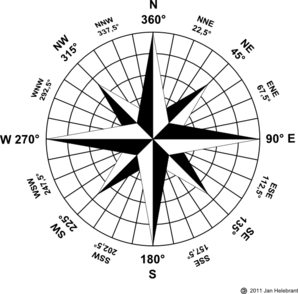

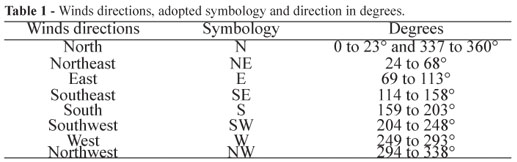

In [31]:
x = Image(filename='WindRose.png') 
y = Image(filename='WindDegrees.jpg') 
display(x, y)

Let's define lists "directions" and "ranges" as below. The last one is expressed by maximum value of each range. To create new column ("Direction_cat") with categorial data we need to use function pandas.cut. Unfortunatelly North is describe by two separate ranges and function cut work only on unique cathegories and elements of ranges must be increasing. Then it's good to create dummy cathegory "NX" for North.

In [32]:
directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW", "NX"]
ranges = [0, 23, 68, 113, 158, 203, 248, 293, 338, 360]

In [33]:
pd.cut(np.array(fm["Wind_Direction"]), ranges, right = True, labels = directions, retbins = True, precision = 2, include_lowest = True)

([SE, S, S, S, S, ..., SE, SE, SE, S, E]
 Length: 33133
 Categories (9, object): [N < NE < E < SE ... SW < W < NW < NX],
 array([  0,  23,  68, 113, 158, 203, 248, 293, 338, 360]))

In [34]:
fm["Direction_cat"] = pd.cut(fm["Wind_Direction"], ranges, right = True, labels = directions, precision = 2, include_lowest = True)

Now we can change our dummy "NX" to "N". We see there are 8 unique cathegories, which is correct.

In [35]:
fm.Direction_cat.replace("NX","N", inplace = True)
fm["Direction_cat"].unique()

[SE, S, E, N, NE, NW, SW, W]
Categories (8, object): [N < NE < E < SE < S < SW < W < NW]

In [36]:
fm.groupby("Direction_cat").count()

,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed,Sunrise_Time,Sunset_Time,Obs_Hour,Date&Hour,Day/Night,Week,Month
Direction_cat,,,,,,,,,,,,,,,
N,3147,3147,3147,3147,3147,3147,3147,3147,3147,3147,3147,3147,3147,3147,3147
NE,4683,4683,4683,4683,4683,4683,4683,4683,4683,4683,4683,4683,4683,4683,4683
E,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437
SE,7778,7778,7778,7778,7778,7778,7778,7778,7778,7778,7778,7778,7778,7778,7778
S,9179,9179,9179,9179,9179,9179,9179,9179,9179,9179,9179,9179,9179,9179,9179
SW,1329,1329,1329,1329,1329,1329,1329,1329,1329,1329,1329,1329,1329,1329,1329
W,833,833,833,833,833,833,833,833,833,833,833,833,833,833,833
NW,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747
NX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
fm.tail()

,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed,Sunrise_Time,Sunset_Time,Obs_Hour,Date&Hour,Day/Night,Week,Month,Direction_cat
33128,2016-12-01,00:20:04,1.22,30.43,102.0,44.0,145.42,6.75,06:41:00,17:42:00,00,2016-12-01 00,Night,48,December,SE
33129,2016-12-01,00:15:01,1.17,30.42,102.0,44.0,117.78,6.75,06:41:00,17:42:00,00,2016-12-01 00,Night,48,December,SE
33130,2016-12-01,00:10:01,1.20,30.42,102.0,44.0,145.19,9.00,06:41:00,17:42:00,00,2016-12-01 00,Night,48,December,SE
33131,2016-12-01,00:05:02,1.23,30.42,101.0,44.0,164.19,7.87,06:41:00,17:42:00,00,2016-12-01 00,Night,48,December,S
33132,2016-12-01,00:00:02,1.20,30.43,101.0,44.0,83.59,3.37,06:41:00,17:42:00,00,2016-12-01 00,Night,48,December,E


The data are well prepared to further analysis, let's order them to make table more clear.

In [38]:
print(fm.columns)

Index(['Date', 'Obs_Time', 'Solar_Radiation', 'Pressure', 'Humidity',
       'Temperature', 'Wind_Direction', 'Wind_Speed', 'Sunrise_Time',
       'Sunset_Time', 'Obs_Hour', 'Date&Hour', 'Day/Night', 'Week', 'Month',
       'Direction_cat'],
      dtype='object')


In [39]:
fm = fm[['Date', 'Obs_Time', 'Solar_Radiation', 'Pressure', 'Humidity',
       'Temperature', 'Wind_Speed', 'Wind_Direction', 'Direction_cat', 'Sunrise_Time',
       'Sunset_Time', 'Obs_Hour', 'Date&Hour', 'Day/Night', 'Week', 'Month',
       ]]

In [40]:
fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33133 entries, 0 to 33132
Data columns (total 16 columns):
Date               33133 non-null object
Obs_Time           33133 non-null object
Solar_Radiation    33133 non-null float64
Pressure           33133 non-null float64
Humidity           33133 non-null float64
Temperature        33133 non-null float64
Wind_Speed         33133 non-null float64
Wind_Direction     33133 non-null float64
Direction_cat      33133 non-null category
Sunrise_Time       33133 non-null object
Sunset_Time        33133 non-null object
Obs_Hour           33133 non-null object
Date&Hour          33133 non-null object
Day/Night          33133 non-null object
Week               33133 non-null object
Month              33133 non-null object
dtypes: category(1), float64(6), object(9)
memory usage: 4.1+ MB


We use .describe() to check all the basic statistics.

In [41]:
fm.describe()

,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Speed,Wind_Direction
count,33133.000000,33133.000000,33133.000000,33133.000000,33133.000000,33133.000000
mean,207.942670,30.423036,75.023119,51.088341,6.260170,143.196205
std,316.615085,0.054427,25.989755,6.200181,3.492808,83.073410
min,1.110000,30.190000,8.000000,34.000000,0.000000,0.090000
25%,1.230000,30.400000,56.000000,46.000000,3.370000,81.920000
50%,2.670000,30.430000,85.000000,50.000000,5.620000,147.370000
75%,355.770000,30.460000,97.000000,55.000000,7.870000,179.120000
max,1601.260000,30.560000,103.000000,71.000000,40.500000,359.950000


In [42]:
print("Coefficient of variation for Solar_Radiation equals " + sp.stats.variation(fm["Solar_Radiation"]).astype(str))

Współczynnik zmienności dla Solar_Radiation to 1.5225845983897695


To check what is the reason of significant variation of the feature we are going to create histogram.

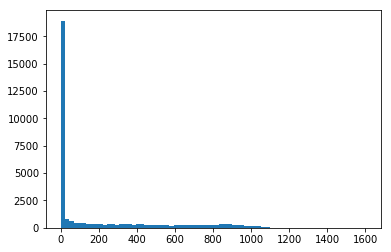

In [43]:
plt.hist(fm["Solar_Radiation"], bins='auto')
plt.show()

Over half of the observations has very small values. It's easy to guess, it must have been data from the nights or days with bad weather conditions. 

In [44]:
low_radiation = fm[fm["Solar_Radiation"]<=5].groupby(["Day/Night", "Obs_Hour"]).count()
low_radiation = low_radiation["Solar_Radiation"]
pd.DataFrame(low_radiation)

Solar_Radiation
Day/Night Obs_Hour                 
Day       06                     40
          07                     32
          08                      3
          17                     49
          18                     28
Night     00                   1216
          01                   1394
          02                   1395
          03                   1396
          04                   1399
          05                   1392
          06                    619
          17                    132
          18                   1231
          19                   1411
          20                   1407
          21                   1400
          22                   1398
          23                   1398

In [45]:
lr_day = low_radiation.loc[["Day"], :].sum()
lr_night = low_radiation.loc[["Night"], :].sum()

print("Number of observations during the day, which are less than 5 equals " + str(lr_day) +
      " co stanowi " + "{:.2%}".format(lr_day/len(fm)) +" of total data.")

print("Number of observations during the night, which are less than 5 equals "+ str(lr_night) + 
      " co stanowi " + "{:.2%}".format(lr_night/len(fm)) +" of total data.")



Liczba obserwacji w ciągu dnia dla Solar_Radiation poniżej 5 wynosi 152 co stanowi 0.46% wszystkich danych.
Liczba obserwacji w ciągu nocy dla Solar_Radiation poniżej 5 wynosi 17188 co stanowi 51.88% wszystkich danych.


Let's check how the histogram and boxplot are for only "day" data.

In [46]:
only_day = fm[fm["Day/Night"]=="Day"]
od = only_day

[]

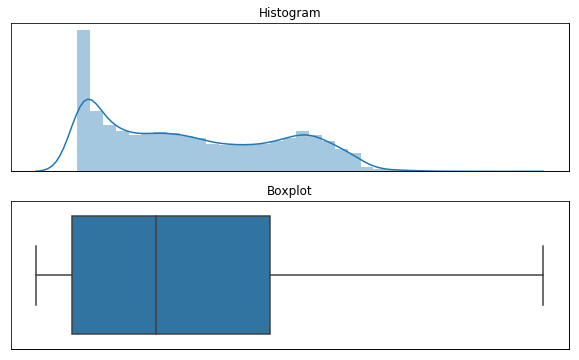

In [47]:
fig, axes = plt.subplots(2,1, sharex = True, sharey = True, figsize = (10,6))
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(2,1,1)
ax1.set_title("Histogram")
sns.distplot([od["Solar_Radiation"]], norm_hist = True, ax = ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax2 = fig.add_subplot(2,1,2)
ax2.set_title("Boxplot")
sns.boxplot([od["Solar_Radiation"]], ax = ax2)
ax2.set_xticks([])
ax2.set_yticks([])


In [48]:
od.describe()

,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Speed,Wind_Direction
count,15843.000000,15843.000000,15843.000000,15843.000000,15843.000000,15843.000000
mean,433.340485,30.423071,73.888910,55.041343,6.302914,126.371189
std,335.096704,0.054133,25.794974,6.049046,3.623790,105.321877
min,1.190000,30.190000,8.000000,36.000000,0.000000,0.100000
25%,113.835000,30.400000,56.000000,50.000000,3.370000,43.035000
50%,380.390000,30.430000,82.000000,55.000000,5.620000,94.880000
75%,737.835000,30.460000,96.000000,60.000000,7.870000,172.860000
max,1601.260000,30.560000,103.000000,71.000000,40.500000,359.940000


We are going to present an averaged solar radiation per hour compared to average of the remaining features. As the wind direction should have been treated as cathegorical data, thus we need to remove for a while column "Wind_Direction" 

In [49]:
fm.dtypes

Date                 object
Obs_Time             object
Solar_Radiation     float64
Pressure            float64
Humidity            float64
Temperature         float64
Wind_Speed          float64
Wind_Direction      float64
Direction_cat      category
Sunrise_Time         object
Sunset_Time          object
Obs_Hour             object
Date&Hour            object
Day/Night            object
Week                 object
Month                object
dtype: object

In [50]:
fm_excl = fm.drop("Wind_Direction", axis =1) ##final_merged with excluded column "Wind_Direction"

Let's group the data by observation hour (gh - grouped by all 24 hours, ghd - grouped by only "Day" hours). Next we are going to use minmax scaler to be able to present data in the one plot.

In [51]:
gh = fm_excl.groupby(["Obs_Hour"]).mean()
ghd = fm_excl[fm_excl["Day/Night"] == "Day"].groupby(["Obs_Hour"]).mean()

In [52]:
ghd.head(12)

,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Speed
Obs_Hour,,,,,
06,17.381991,30.429033,73.637807,47.181818,6.650188
07,129.888808,30.429744,72.932699,48.781273,5.982136
08,371.947171,30.442953,69.366228,53.477339,5.423428
09,552.518521,30.452287,68.938092,55.527312,5.778157
10,684.560443,30.451888,68.936093,56.883805,6.401866
11,714.474786,30.440346,69.577320,57.537555,6.734404
12,727.868328,30.424677,71.378299,57.853372,7.132786
13,649.836779,30.407704,72.875179,57.821377,7.096126
14,514.964035,30.397666,76.156340,57.054035,6.997197


In [53]:
gh.columns, ghd.columns

(Index(['Solar_Radiation', 'Pressure', 'Humidity', 'Temperature', 'Wind_Speed'], dtype='object'),
 Index(['Solar_Radiation', 'Pressure', 'Humidity', 'Temperature', 'Wind_Speed'], dtype='object'))

In [54]:
x1 = gh.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x1_scaled = min_max_scaler.fit_transform(x1)
gh = pd.DataFrame(x1_scaled,columns = gh.columns)

x2 = ghd.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x2_scaled = min_max_scaler.fit_transform(x2)
ghd = pd.DataFrame(x2_scaled,columns = ghd.columns)


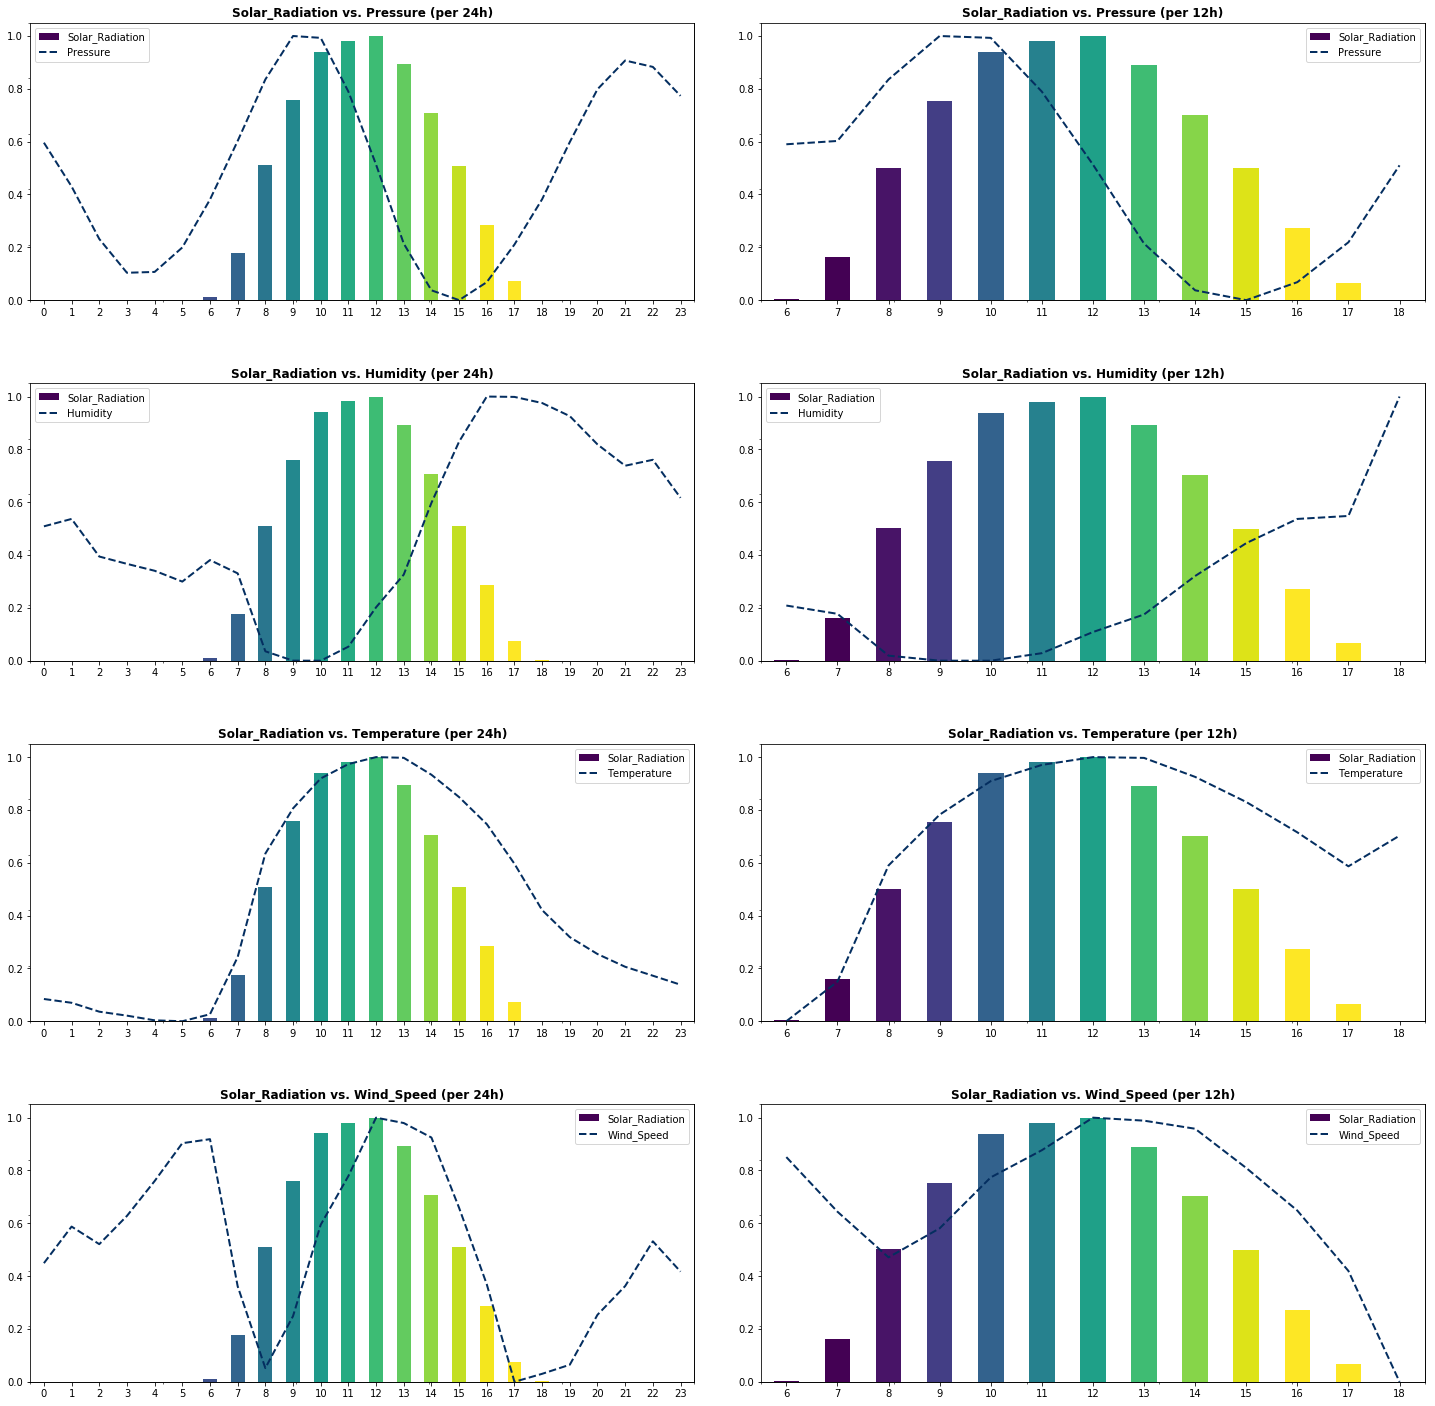

In [55]:
from matplotlib import cm
color1 = cm.viridis(np.linspace(-0.2, 1.5, 24))
color2 = cm.viridis(np.linspace(-0.2, 1.2, 12))


fig, axes = plt.subplots(4,2, sharex = True , sharey = True, figsize = (25,25))
plt.xticks([])
plt.yticks([])

for i in range(len(gh.columns)-1):
   
    ax1 = fig.add_subplot(4,2,2*i+1)
    ax1.set_title(gh.columns[0] + " vs. " + gh.columns[i+1] + " (per 24h)", fontweight = "bold")
    gh.plot(y=gh.columns[0], kind = 'bar', ax = ax1, color=color1)
    gh.plot(y=gh.columns[i+1], ax=ax1, color = '#042e60', style='--', linewidth = 2.0)
    #ax1.set_yticks([])
    
    ax2 = fig.add_subplot(4,2,2*i+2)
    ax2.set_title(ghd.columns[0] + " vs. " + ghd.columns[i+1] + " (per 12h)", fontweight = "bold")
    ghd.plot(kind='bar',y=ghd.columns[0],ax=ax2, color = color2)
    ghd.plot(kind='line',y=ghd.columns[i+1], ax=ax2, color = '#042e60', style = '--', linewidth = 2.0)
    ax2.set_xticklabels([6,7,8,9,10,11,12,13,14,15,16,17,18])
    #ax2.set_yticks([])


plt.subplots_adjust(wspace = 0.1, hspace = 0.3 )
plt.show()

From the above plots we can conclude, there is positive correlation between averedged solar radiation and temperature, wind speed and pressure. It seems the greatest is with temperature. On the other hand we see the humidity would have negative impact on solar radiation. Furthermore correlation for Solar_Radiation vs Wind Speed/Pressure would be smaller for the whole data than for the one collected only through day. It easy to spot there is 12-hours trend for mentioned features (at least two peaks throughout the 24-hours) while the averaged solar radiation has only one peak per day.  We can confirm our assumptions to the correlation matrices. 

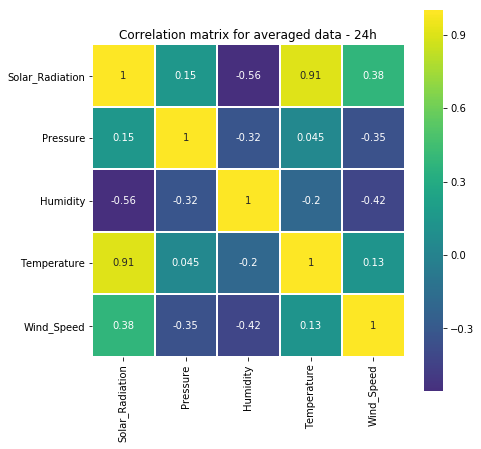

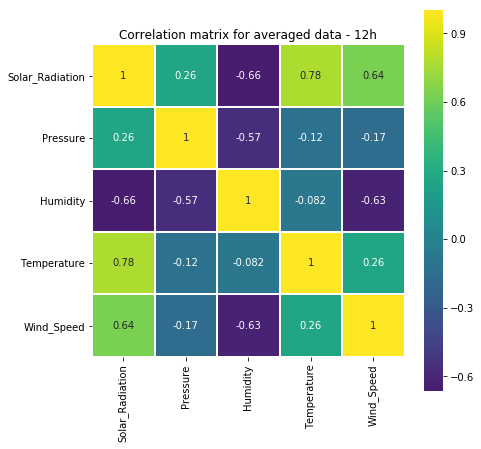

In [56]:
corrmat = gh.corr()
plt.figure(figsize=(7,7))
plt.title("Correlation matrix for averaged data - 24h")
sns.heatmap(corrmat, cmap="viridis", center = 0.1, square=True, linewidths=1.0, annot=True)


corrmat = ghd.corr()
plt.figure(figsize=(7,7))
plt.title("Correlation matrix for averaged data - 12h")
sns.heatmap(corrmat, cmap="viridis", center = 0.1, square=True, linewidths=1.0,  annot=True)

We see our assumptions are confirmed. Furthermore temperature would be the best predictor for solar radiation.

Let's take a look on wind direction now.

In [57]:
wind = od.groupby("Direction_cat").mean()
wind.drop("Wind_Direction", axis = 1)

,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Speed
Direction_cat,,,,,
N,551.619408,30.426060,72.347484,58.155769,5.473026
NE,540.166273,30.430604,72.854711,57.189936,6.086280
E,454.594327,30.434687,74.923636,55.212000,6.128145
SE,304.037495,30.435078,74.383834,52.611934,6.789353
S,176.550662,30.428077,70.786255,49.593317,6.394262
SW,257.145843,30.379070,69.331395,50.991279,8.281105
W,332.656857,30.356000,80.623810,50.807143,7.626095
NW,418.178320,30.377367,79.824911,54.525979,7.194292
NX,NaN,NaN,NaN,NaN,NaN


In [58]:
wind.dropna(inplace = True)
wind

,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Speed,Wind_Direction
Direction_cat,,,,,,
N,551.619408,30.426060,72.347484,58.155769,5.473026,115.949264
NE,540.166273,30.430604,72.854711,57.189936,6.086280,44.545042
E,454.594327,30.434687,74.923636,55.212000,6.128145,88.121247
SE,304.037495,30.435078,74.383834,52.611934,6.789353,135.548138
S,176.550662,30.428077,70.786255,49.593317,6.394262,176.162207
SW,257.145843,30.379070,69.331395,50.991279,8.281105,222.274273
W,332.656857,30.356000,80.623810,50.807143,7.626095,274.845929
NW,418.178320,30.377367,79.824911,54.525979,7.194292,319.502327


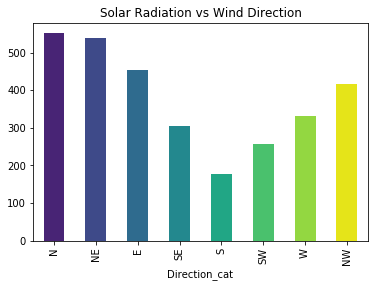

In [59]:
color3 = cm.viridis(np.linspace(0.1, 0.96, 8))
wind["Solar_Radiation"].plot(kind = 'bar', color = color3, title = "Solar Radiation vs Wind Direction")

On basis of the above barplot the averaged solar radiation is the highest for northern winds.

Taking into the consideration all collected data, temperature is the best correlated with solar radiation. On the below interactive plot you can find how these features are changing through the three months. Data has been scaled to allow them to be presented on the one plot.

In [60]:
rt = fm[fm["Month"]!="December"]
rt.tail()

,Date,Obs_Time,Solar_Radiation,Pressure,Humidity,Temperature,Wind_Speed,Wind_Direction,Direction_cat,Sunrise_Time,Sunset_Time,Obs_Hour,Date&Hour,Day/Night,Week,Month
24964,2016-11-01,00:25:18,1.26,30.47,52.0,47.0,5.62,154.28,SE,06:24:00,17:48:00,00,2016-11-01 00,Night,44,November
24965,2016-11-01,00:20:19,1.31,30.48,56.0,47.0,4.50,151.32,SE,06:24:00,17:48:00,00,2016-11-01 00,Night,44,November
24966,2016-11-01,00:15:20,1.30,30.48,54.0,47.0,3.37,161.90,S,06:24:00,17:48:00,00,2016-11-01 00,Night,44,November
24967,2016-11-01,00:10:18,1.31,30.48,55.0,47.0,5.62,140.94,SE,06:24:00,17:48:00,00,2016-11-01 00,Night,44,November
24968,2016-11-01,00:00:19,1.26,30.48,55.0,47.0,3.37,120.18,SE,06:24:00,17:48:00,00,2016-11-01 00,Night,44,November


In [61]:
rt = rt.groupby(["Date&Hour"]).mean().loc[:, ["Solar_Radiation", "Temperature"]]#radiation vs temperature
rt = rt.fillna(fm.mean())

In [62]:
x3 = rt.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x3_scaled = min_max_scaler.fit_transform(x3)
rt = pd.DataFrame(x3_scaled, index = rt.index, columns = rt.columns)

In [63]:
init_notebook_mode(connected=True)

trace1 = go.Scatter(x=list(rt.index), y=list(rt.Solar_Radiation), mode='lines',
                    line = dict(color = ("#fdd737"), width = 2.0, dash = 'solid'), name = "Solar_Radiation")
                  
trace2 = go.Scatter(x=list(rt.index), y=list(rt.Temperature), mode='lines',
                    line = dict(color = ("#5d52d6"), width = 2.0,dash = 'dot'), name = "Temperature")

data = [trace1, trace2]
layout = dict(
    title='Solar radiation vs Temperature - time series',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=3, label='3d', step='day', stepmode='backward'),
                dict(count=5, label='5d', step='day', stepmode='backward'),
                dict(count=7, label='7d', step='day',stepmode='backward'),
                dict(count=10, label='10d',step='day', stepmode='backward'),
                dict(count=20,label='20d',step='day', stepmode='backward'),
                dict(count=1, label='1m', step='month', stepmode='backward')
            ])
        ),
        rangeslider=dict(visible = True), type='date'))

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)

On the below there are plots showing pairwise relationships. They shows there is no specific dependence between each other, except temperature and solar radiation. There might be a linear regression.

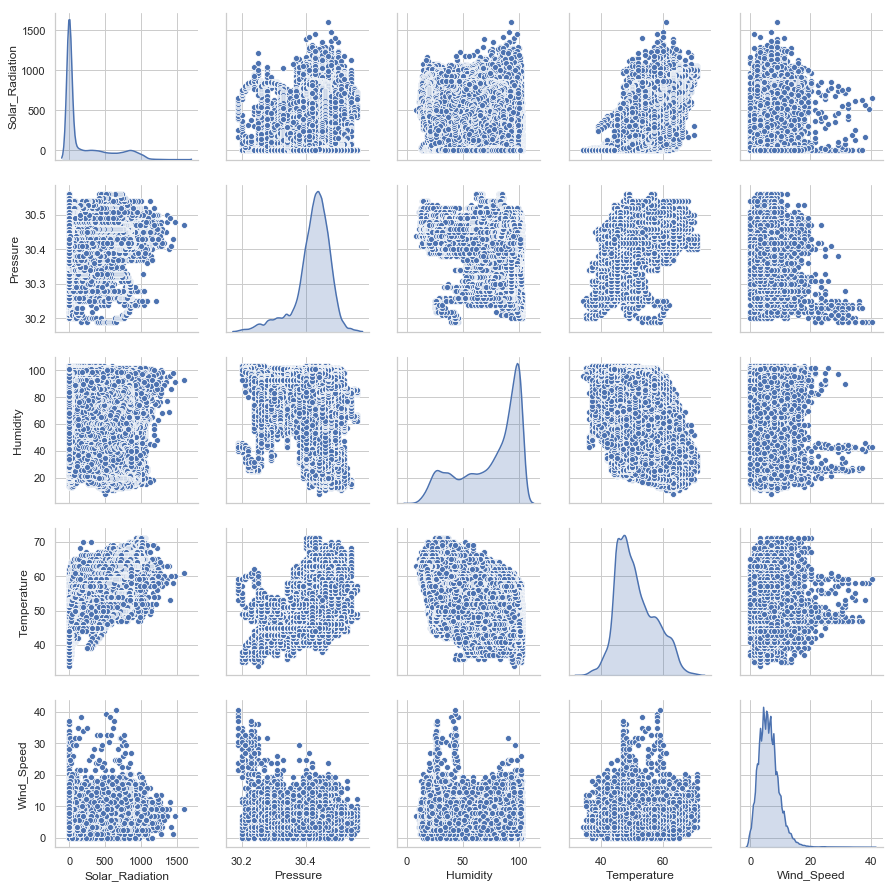

In [64]:
sns.set(style = 'whitegrid', context = 'notebook')
cols_1 = ['Solar_Radiation', 'Pressure', 'Humidity', 'Temperature', 'Wind_Speed']
sns.pairplot(fm[cols_1], diag_kind = 'kde')
plt.show()

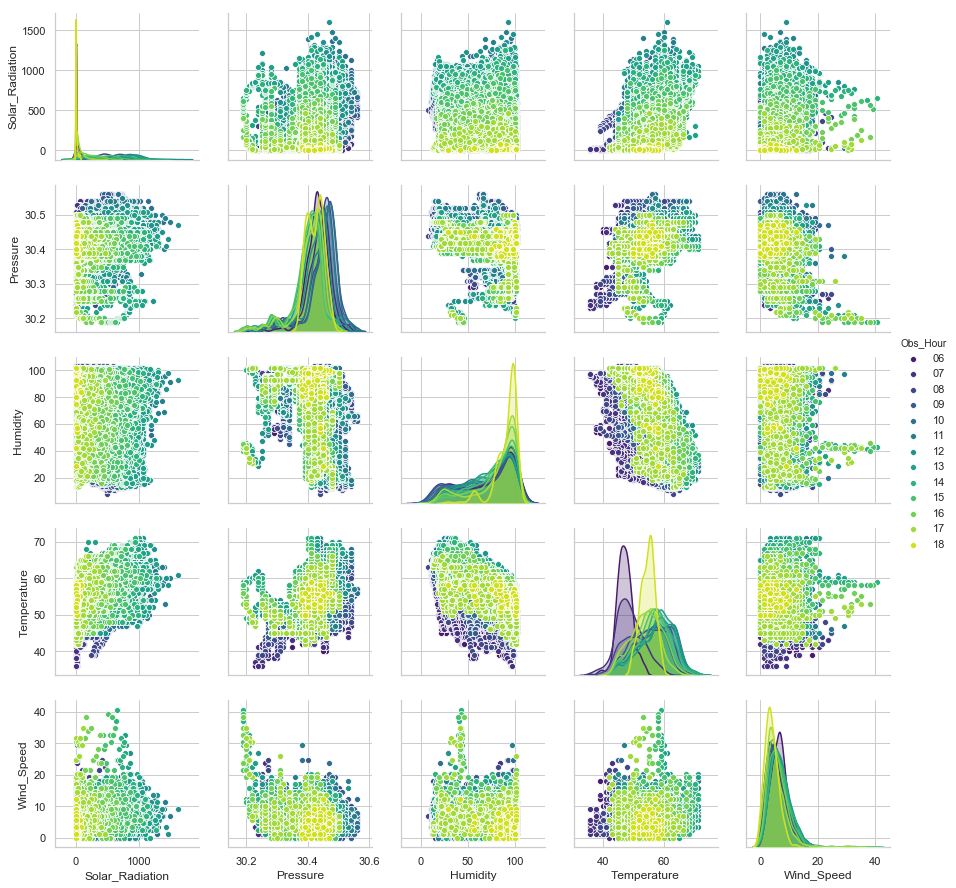

In [65]:
sns.set(style = 'whitegrid', context = 'notebook')
cols_2 = ['Solar_Radiation', 'Pressure', 'Humidity', 'Temperature', 'Wind_Speed']
cols_3 = ['Solar_Radiation', 'Pressure', 'Humidity', 'Temperature', 'Wind_Speed', 'Obs_Hour']
sns.pairplot(od[cols_3], vars = cols_2, hue = 'Obs_Hour', diag_kind = 'kde', palette = 'viridis')
plt.show()

We are going to use regrssion models due to fact the solar radiation is continuous variable and we won't be able to find a few class for this feature. 

# Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
import sklearn.model_selection as modsel
from sklearn.model_selection import train_test_split

C:\Users\patka\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



X_total - all data
X_od - data only from the day

We are going to check which data set gives better accuracy.

In [67]:
X_total = fm[['Pressure', 'Humidity','Temperature', 'Wind_Speed', 'Obs_Hour']]
X_od = od[['Pressure', 'Humidity','Temperature', 'Wind_Speed', 'Obs_Hour']]

In [68]:
y_total = fm['Solar_Radiation'].values
y_od = od['Solar_Radiation'].values

The data has been splitted into train 80% and test 20%. Random state is set as integer, because we want the results to be reccurent.

In [69]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

In [70]:
X_train_od, X_test_od, y_train_od, y_test_od = train_test_split(X_od, y_od, test_size=0.2, random_state=42)

In [71]:
reg_total = LinearRegression()
reg_total.fit(X_train_t, y_train_t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [72]:
reg_od = LinearRegression()
reg_od.fit(X_train_od, y_train_od)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
pd.DataFrame({'type':['Total', 'Only_Day'], 
              'R^2 score': [reg_total.score(X_train_t, y_train_t), reg_od.score(X_train_od, y_train_od)]})

,type,R^2 score
0,Total,0.578217
1,Only_Day,0.488022


R^2 score is higher for total data, then better accuracy is for this dataset. Let's check through cross validation if used model is good.

In [74]:
X_train_t.shape, X_test_t.shape, y_train_t.shape, y_test_t.shape

((26506, 5), (6627, 5), (26506,), (6627,))

In [75]:
scores_reg = modsel.cross_val_score(reg_total, X_train_t, y_train_t, cv=10)
scores_reg

array([0.57432961, 0.58718744, 0.55882312, 0.57933859, 0.5805541 ,
       0.5936624 , 0.5653945 , 0.56167673, 0.5747869 , 0.6002813 ])

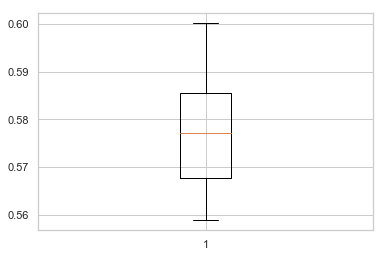

In [76]:
_ = plt.boxplot(scores_reg)

In [77]:
print("Mean: " + str(scores_reg.mean()) + '\n' + "Standard deviation: " + str(scores_reg.std()) +
      '\n' + "Statistical discpersion: " + str(max(scores_reg)-min(scores_reg)))

Średnia: 0.577603467869185
Odchylenie standardowe: 0.012844513246193977
Rozrzut: 0.04145817862049772


From the above we see the dispersion is slight, standard deviation small, thus we can assume it's good model to predict solar radiation.

In [78]:
pd.DataFrame({'Names': X_total.columns.tolist(), 'Coeffs': reg_total.coef_})

,Names,Coeffs
0,Pressure,-606.987981
1,Humidity,0.069018
2,Temperature,40.596133
3,Wind_Speed,7.497984
4,Obs_Hour,-6.318687


In [79]:
print("Intercept: " + str(reg_total.intercept_))

Intercept: 16620.70032785445


Przejdźmy teraz do sprawdzenia modelu na danych testowych. Porównamy je następnie na wykresie z danymi rzeczywistymi (dla 70 wybranych obserwacji).

In [80]:
y_pred_reg = reg_total.predict(X_test_t)

Text(0.5, 0, 'Time')

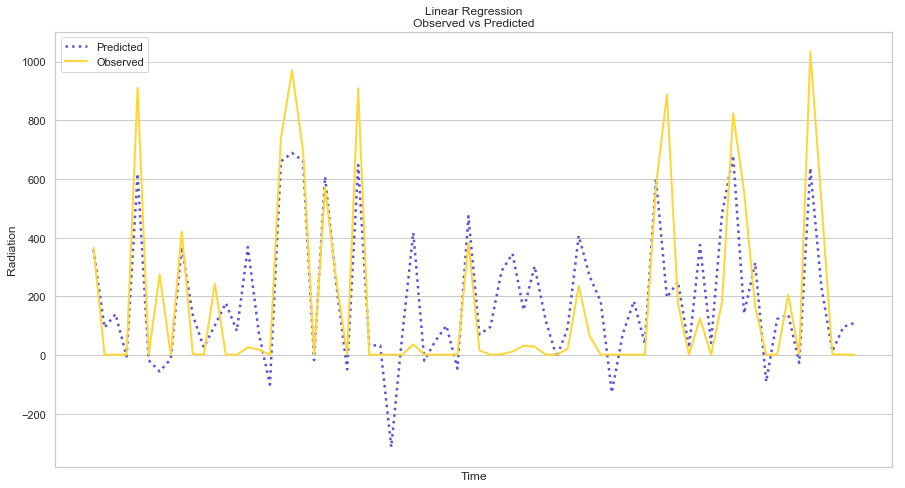

In [81]:
plt.figure(figsize = (15,8))
plt.xticks([])

plt.plot(y_pred_reg[:70], c=("#5d52d6"), linestyle = 'dotted', linewidth =2.5, label='Predicted') 
plt.plot(y_test_t[:70], c=("#fdd737"), linewidth = 2, label='Observed')
plt.title('Linear Regression' + '\n' + 'Observed vs Predicted')
plt.legend(['Predicted', 'Observed'])
plt.ylabel('Radiation')
plt.xlabel('Time')

In [82]:
pd.DataFrame({'Dataset':['Train', 'Test'], 
              'R^2 score': [reg_total.score(X_train_t, y_train_t), reg_total.score(X_test_t, y_test_t)]})

,Dataset,R^2 score
0,Train,0.578217
1,Test,0.585026


In [83]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_t, y_pred_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_t, y_pred_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_t, y_pred_reg)))

Mean Absolute Error: 157.12446238373525
Mean Squared Error: 42327.67547060536
Root Mean Squared Error: 205.73690838205323


Pomimo tego, że model nie ma problemu z nadmiernym dopasowaniem (R^2 dla danych treningowych i testowych jest praktycznie takie samo) to dokładność jest niska R^2 ~ 0.6. Nie jest to zadawalajacym wynikiem. Patrząc na wykres już na pierwszy rzut oka widać że model przewiduje ujemne wartości dla promieniowania słoneczngeo, co w rzeczywistości nie ma prawa być obserwowalne.

# Decision Tree

In [84]:
 dt = DecisionTreeRegressor()

In [85]:
scores_dt_total = modsel.cross_val_score(dt, X_train_t, y_train_t, cv=10)
scores_dt_total

array([0.84254375, 0.85463539, 0.83902716, 0.83542474, 0.85613683,
       0.85455577, 0.83021698, 0.83297022, 0.82920353, 0.85456836])

In [86]:
scores_dt_od = modsel.cross_val_score(dt, X_train_od, y_train_od, cv=10)
scores_dt_od

array([0.69763018, 0.69139019, 0.69912746, 0.63771818, 0.72098876,
       0.72830594, 0.71746307, 0.75286641, 0.68719883, 0.70491041])

Ponownie model dla wszystkich danych wydaje się być dokładniejszy.

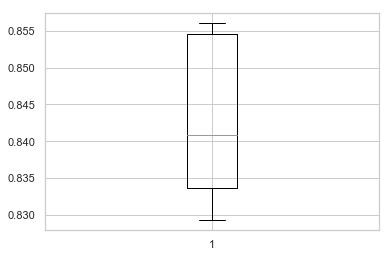

In [87]:
_ = plt.boxplot(scores_dt_total)

In [88]:
print("Średnia: " + str(scores_dt_total.mean()) + '\n' + "Odchylenie standardowe: " + str(scores_dt_total.std()) +
      '\n' + "Rozrzut: " + str(max(scores_dt_total)-min(scores_dt_total)))

Średnia: 0.842928272938958
Odchylenie standardowe: 0.010502336655754568
Rozrzut: 0.026933299989321258


Ustalmy kilka możliwych wartości parametrów modelu, a następnie za pomocą 3-krotnej walidacji krzyżowej dowiemy się, która kombinacja jest najlepsza.

In [89]:
params_grid = {
    'max_depth': [ 3, 6, 9], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 3, 5], 
    'max_features': [None, 'auto', 'sqrt'] 
}

In [90]:
grid_search_dt = modsel.GridSearchCV(dt, param_grid = params_grid, n_jobs=3, cv = 3)

In [91]:
best_grid_dt = grid_search_dt.fit(X_train_t, y_train_t)

Przyjmując poniższą kombinację parametrów uzyskamy model z najlepszą trafnością (0.8898)

In [92]:
best_grid_dt.best_params_

{'max_depth': 9,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [93]:
best_grid_dt.score(X_train_t, y_train_t)

0.8898086856119088

In [94]:
best_model_dt = best_grid_dt.best_estimator_
best_model_dt

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [95]:
y_pred_dt = best_model_dt.predict( X_test_t)

Text(0.5, 0, 'Time')

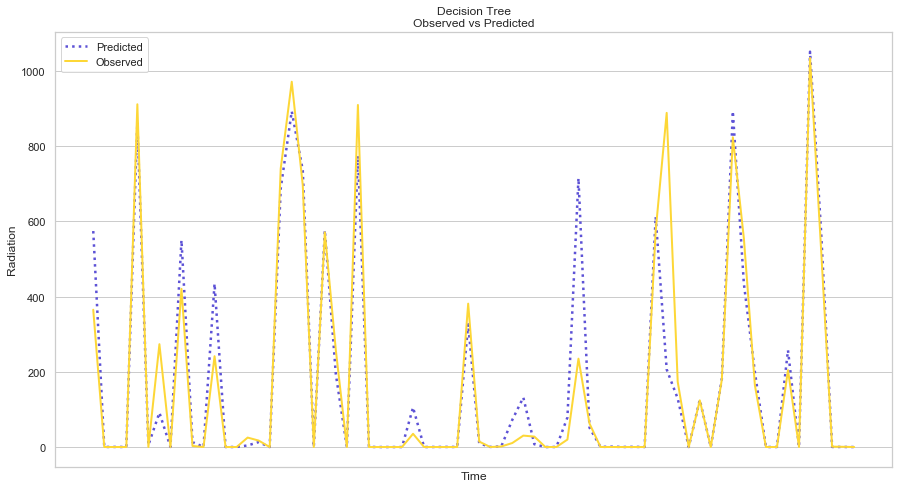

In [96]:
plt.figure(figsize = (15,8))
plt.xticks([])

# plot results
plt.plot(y_pred_dt[:70], c=("#5d52d6"), linestyle = 'dotted', linewidth =2.5, label='Predicted') 
plt.plot(y_test_t[:70], c=("#fdd737"), linewidth = 2, label='Observed')
plt.title('Decision Tree' + '\n' + 'Observed vs Predicted')
plt.legend(['Predicted', 'Observed'])
plt.ylabel('Radiation')
plt.xlabel('Time')

In [97]:
pd.DataFrame({'Dataset':['Train', 'Test'], 
              'Score': [best_model_dt.score(X_train_t, y_train_t), best_model_dt.score(X_test_t, y_test_t)]})

,Dataset,Score
0,Train,0.889809
1,Test,0.878555


Ten model jest zdecydowanie lepszy niż regresja liniowa, porównując wykresy widzimy lepsze dopasowanie, zniknął rownież problem ujemnych wartości promieniowania słonecznego.

# Random forest

In [98]:
rf = RandomForestRegressor()  

In [99]:
scores_rf_total = modsel.cross_val_score(rf, X_train_t, y_train_t, cv=10)
scores_rf_total

array([0.89534531, 0.91265457, 0.88908727, 0.88819656, 0.91053336,
       0.90336589, 0.89535274, 0.88993504, 0.90534638, 0.90751406])

In [100]:
scores_rf_od = modsel.cross_val_score(rf, X_train_od, y_train_od, cv=10)
scores_rf_od

array([0.81654893, 0.79709895, 0.79797243, 0.80856664, 0.81246079,
       0.83487581, 0.81411098, 0.83545108, 0.81208479, 0.81665768])

Model przyniesie lepsze efekty jeśli do anazlizy użyjemy wszystkich danych.

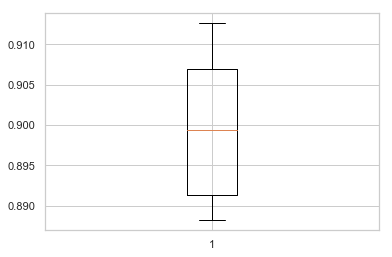

In [101]:
_ = plt.boxplot(scores_rf_total)

In [102]:
print("Średnia: " + str(scores_rf_total.mean()) + '\n' + "Odchylenie standardowe: " + str(scores_rf_total.std()) +
      '\n' + "Rozrzut: " + str(max(scores_rf_total)-min(scores_rf_total)))

Średnia: 0.8997331186429784
Odchylenie standardowe: 0.008773408789878452
Rozrzut: 0.0244580057422763


In [103]:
params_grid_rf = {
    'n_estimators': [5, 10, 15],
    'max_features': [None, 'auto', 'sqrt'],
    'max_depth': [3, 6, 9, 11],
    'n_jobs' : [-1,1]
}

In [104]:
grid_search_rf = modsel.GridSearchCV(rf, param_grid = params_grid_rf, n_jobs=3, cv = 3)

In [105]:
best_grid_rf = grid_search_rf.fit(X_train_t, y_train_t)

In [106]:
best_grid_rf.best_params_

{'max_depth': 11, 'max_features': 'auto', 'n_estimators': 15, 'n_jobs': -1}

In [107]:
best_grid_rf.score(X_train_t, y_train_t)

0.9279987099341196

In [108]:
best_grid_rf.score(X_test_t, y_test_t)

0.9033258120250246

In [109]:
best_model_rf = best_grid_rf.best_estimator_
best_model_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [110]:
y_pred_rf = best_model_rf.predict( X_test_t)

Text(0.5, 0, 'Time')

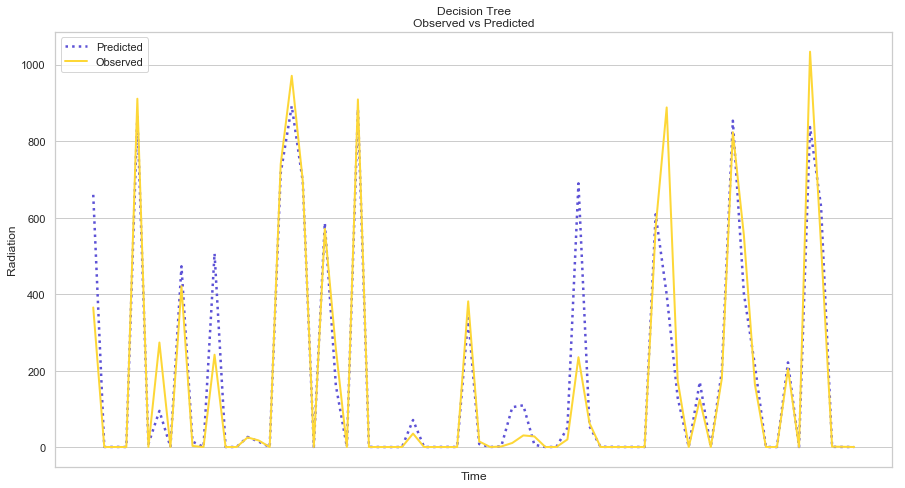

In [111]:
plt.figure(figsize = (15,8))
plt.xticks([])

# plot results
plt.plot(y_pred_rf[:70], c=("#5d52d6"), linestyle = 'dotted', linewidth =2.5, label='Predicted') 
plt.plot(y_test_t[:70], c=("#fdd737"), linewidth = 2, label='Observed')
plt.title('Decision Tree' + '\n' + 'Observed vs Predicted')
plt.legend(['Predicted', 'Observed'])
plt.ylabel('Radiation')
plt.xlabel('Time')

In [112]:
pd.DataFrame({'Dataset':['Train', 'Test'], 
              'Score': [best_model_rf.score(X_train_t, y_train_t), best_model_rf.score(X_test_t, y_test_t)]})

,Dataset,Score
0,Train,0.927999
1,Test,0.903326


Ten model osiąga ponad 90% trafności. Poniżej porównanie wszystkich omówionych modeli.

In [113]:
pd.DataFrame({'Dataset':['Linear Regression', 'Decision Tree', 'Random Forest'], 
              'Score': [reg_total.score(X_test_t, y_test_t),best_model_dt.score(X_test_t, y_test_t), 
                        best_model_rf.score(X_test_t, y_test_t)]})

,Dataset,Score
0,Linear Regression,0.585026
1,Decision Tree,0.878555
2,Random Forest,0.903326


Modele Decision Tree i Random Forest przynoszą porównywalnie dobre wyniki. Regresja liniowa niestety kiepsko wypada na tle pozostałych, ale wynika to ze struktury danych.